This notebook is in some ways a continuation of the next one: https://www.kaggle.com/code/sndorburian/using-sentinel-satellite-images/notebook#Water-on-satellite-images

In [1]:
!pip install sentinelhub
!pip install rasterio

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.8/249.8 kB 4.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 7.1 MB/s eta 0:00:00
  Created wheel for utm: filename=utm-0.7.0-py3-none-any.whl size=6084 sha256=aa198744b1edd9d7c2f32338befede477087372b40c11af53af6db59dd35b9c8
  Stored in directory: /root/.cache/pip/wheels/2f/a1/c8/543df0e8f5e824c3e92a432e32deb9cd89ae686095ee8cfcbe
Successfully built utm
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 65.0 MB/s eta 0:00:00:00:0100:01


In [2]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
sentinel_client_id = user_secrets.get_secret("sentinel_client_id")
sentinel_client_secret = user_secrets.get_secret("sentinel_client_secret")
sentinel_id = user_secrets.get_secret("sentinel_id")


# Configuration for SentinelHub
from sentinelhub import SHConfig
config = SHConfig()
config.instance_id = sentinel_id
config.sh_client_id = sentinel_client_id
config.sh_client_secret = sentinel_client_secret

# Get the Sentinel image

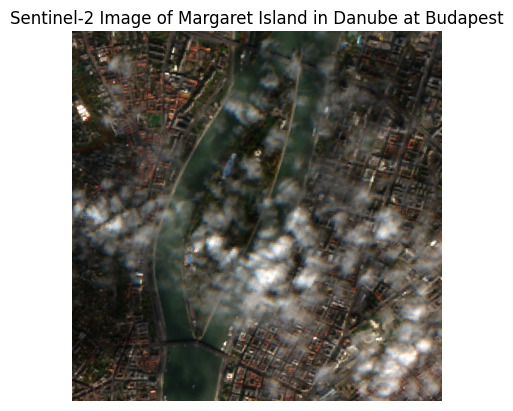

In [3]:
from sentinelhub import SHConfig, SentinelHubRequest, DataCollection, MimeType, CRS, BBox
import matplotlib.pyplot as plt
import numpy as np

# set coordinates
bbox = BBox(bbox=[19.03, 47.51, 19.07, 47.54], crs=CRS.WGS84)


# get the image
evalscript = """
//VERSION=3
function setup() {
    return {
        input: ["B04", "B03", "B02"],
        output: { bands: 3 }
    };
}

function evaluatePixel(sample) {
    return [sample.B04, sample.B03, sample.B02];
}
"""
def getImage(bbox):
    request = SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=('2024-10-01', '2024-10-31')
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.TIFF)
        ],
        bbox=bbox,
        size=(512, 512),
        config=config
    )
    return request

request = getImage(bbox)
response = request.get_data()
image = response[0]

# set this to make the image brighter or darker. increase to make it darker
normalization_factor = 100  

# show the image
image = np.clip(image / normalization_factor, 0, 1)
plt.imshow(image)
plt.title('Sentinel-2 Image of Margaret Island in Danube at Budapest')
plt.axis('off')
plt.show()

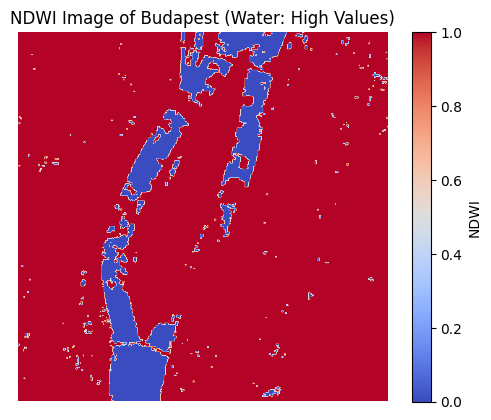

In [4]:
# Import necessary libraries
import rasterio
from sentinelhub import BBox, CRS, DataCollection, SentinelHubRequest, MimeType
import matplotlib.pyplot as plt
import numpy as np

# Set coordinates (Budapest area)
bbox = BBox(bbox=[19.03, 47.51, 19.07, 47.54], crs=CRS.WGS84)


# Function to calculate NDWI and visualize the image
def get_and_visualize_ndwi(bbox, title):
    # Sentinel Hub evalscript for NDWI calculation
    evalscript = """
    //VERSION=3
    function setup() {
        return {
            input: ["B08", "B02"],
            output: { bands: 1 }
        };
    }

    function evaluatePixel(sample) {
        // Calculate NDWI
        const ndwi = (sample.B08 - sample.B02) / (sample.B08 + sample.B02);
        return [ndwi];
    }
    """

    # Create Sentinel Hub request
    request = SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=('2024-10-01', '2024-10-31')
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.TIFF)
        ],
        bbox=bbox,
        size=(512, 512),
        config=config
    )

    # Get data from Sentinel Hub
    response = request.get_data()
    ndwi_image = response[0]

    # Clip and normalize NDWI values
    ndwi_image = np.clip(ndwi_image, -1, 1)  # Ensure NDWI values are within valid range
    normalized_image = (ndwi_image - ndwi_image.min()) / (ndwi_image.max() - ndwi_image.min())

    # Visualize NDWI image
    plt.imshow(normalized_image, cmap='coolwarm')
    plt.title(title)
    plt.colorbar(label='NDWI')
    plt.axis('off')
    plt.show()

# Get and visualize NDWI image
get_and_visualize_ndwi(bbox, 'NDWI Image of Budapest (Water: High Values)')

Let's see the Margaret Bridge from the image!

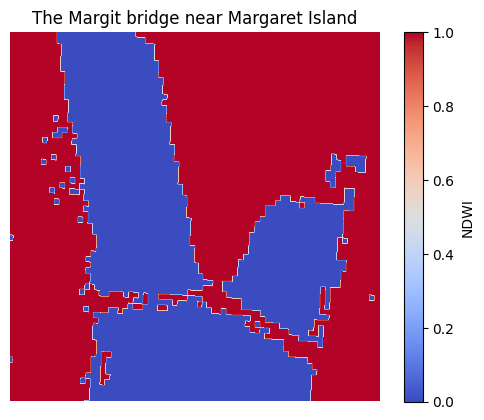

In [5]:
bbox = BBox(bbox=[19.038, 47.513, 19.048, 47.519], crs=CRS.WGS84)
get_and_visualize_ndwi(bbox, 'The Margit bridge near Margaret Island')

# Measure the length of the bridge!

In [6]:
!pip install geopy

To measure the distance between two coordinates:

In [7]:
from geopy.distance import geodesic

# Set the end points of the bridge
margit_hid_start = (47.51471344556954, 19.039797903345697)  # end at North
margit_hid_end = (47.513583051755816, 19.04651425527539)    # end at South

# get the distance
distance = geodesic(margit_hid_start, margit_hid_end).meters
print(f"The length of the Margaret Bridge: {distance:.2f} m")


The length of the Margaret Bridge: 521.28 m


Let's put it on the map!

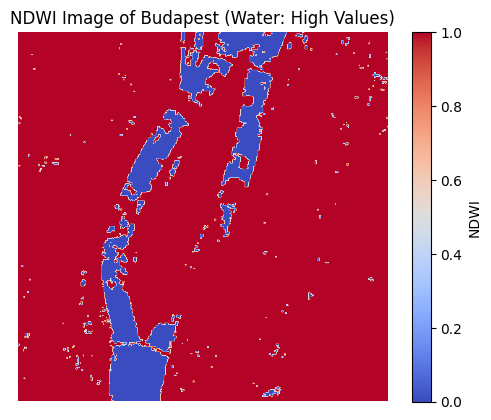

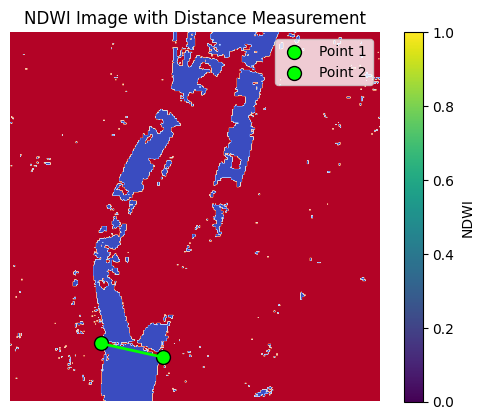

The distance between the points is approximately 521.28 meters.


In [8]:
from geopy.distance import geodesic
from sentinelhub import BBox, CRS, DataCollection, SentinelHubRequest, MimeType
import matplotlib.pyplot as plt
import numpy as np

# Set coordinates (Budapest area)
bbox = BBox(bbox=[19.03, 47.51, 19.07, 47.54], crs=CRS.WGS84)

# Function to calculate NDWI and visualize the image
def get_and_visualize_ndwi(bbox, title):
    # Sentinel Hub evalscript for NDWI calculation
    evalscript = """
    //VERSION=3
    function setup() {
        return {
            input: ["B08", "B02"],
            output: { bands: 1 }
        };
    }

    function evaluatePixel(sample) {
        // Calculate NDWI
        const ndwi = (sample.B08 - sample.B02) / (sample.B08 + sample.B02);
        return [ndwi];
    }
    """

    # Create Sentinel Hub request
    request = SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=('2024-10-01', '2024-10-31')
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.TIFF)
        ],
        bbox=bbox,
        size=(512, 512),
        config=config
    )

    # Get data from Sentinel Hub
    response = request.get_data()
    ndwi_image = response[0]

    # Clip and normalize NDWI values
    ndwi_image = np.clip(ndwi_image, -1, 1)  # Ensure NDWI values are within valid range
    normalized_image = (ndwi_image - ndwi_image.min()) / (ndwi_image.max() - ndwi_image.min())

    # Visualize NDWI image
    plt.imshow(normalized_image, cmap='coolwarm')
    plt.title(title)
    plt.colorbar(label='NDWI')
    plt.axis('off')
    plt.show()

    return normalized_image

# Get and visualize NDWI image
ndwi_image = get_and_visualize_ndwi(bbox, 'NDWI Image of Budapest (Water: High Values)')

# Function to convert geographic coordinates to pixel coordinates
def geo_to_pixel(geo, bbox, image_shape):
    lat, lon = geo
    height, width = image_shape
    min_lon, min_lat, max_lon, max_lat = bbox
    x = int((lon - min_lon) / (max_lon - min_lon) * width)
    y = int((max_lat - lat) / (max_lat - min_lat) * height)
    return x, y

# Geographic coordinates for measurement
geo_point1 = (47.51471344556954, 19.039797903345697)
geo_point2 = (47.513583051755816, 19.04651425527539)

# Convert geographic coordinates to pixel coordinates
pixel_point1 = geo_to_pixel(geo_point1, bbox, ndwi_image.shape)
pixel_point2 = geo_to_pixel(geo_point2, bbox, ndwi_image.shape)

# Measure distance between the points on the image and draw a green line with markers
def measure_distance_on_image(image, pixel_point1, pixel_point2):
    # Draw a green line on the image between the points and mark the points with green markers
    plt.imshow(image, cmap='coolwarm')
    plt.plot([pixel_point1[0], pixel_point2[0]], [pixel_point1[1], pixel_point2[1]], color='lime', linewidth=2)
    
    plt.scatter(*pixel_point1, color='lime', s=100, edgecolor='black', label='Point 1')
    plt.scatter(*pixel_point2, color='lime', s=100, edgecolor='black', label='Point 2')

    plt.title('NDWI Image with Distance Measurement')
    plt.colorbar(label='NDWI')
    plt.axis('off')
    plt.legend()
    plt.show()

    # Measure distance between geographic coordinates
    distance = geodesic(geo_point1, geo_point2).meters
    return distance

# Measure distance and visualize
distance = measure_distance_on_image(ndwi_image, pixel_point1, pixel_point2)
print(f"The distance between the points is approximately {distance:.2f} meters.")


Which is pretty close to the [official data](https://en.wikipedia.org/wiki/Margaret_Bridge): 607.6 m

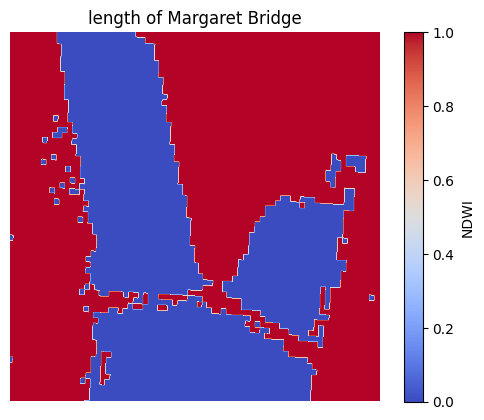

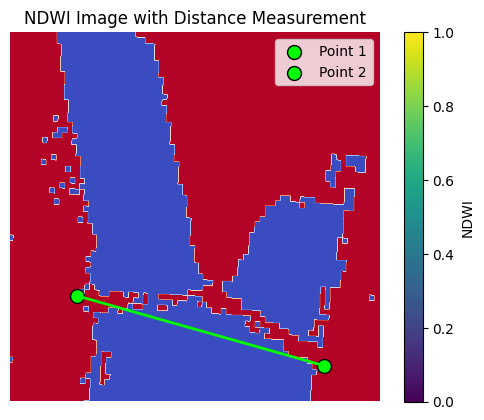

The distance between the points is approximately 521.28 meters.


In [9]:
bbox = BBox(bbox=[19.038, 47.513, 19.048, 47.519], crs=CRS.WGS84)

image = get_and_visualize_ndwi(bbox, 'length of Margaret Bridge')
margit_hid_start = (47.51471344556954, 19.039797903345697)  # end at North
margit_hid_end = (47.513583051755816, 19.04651425527539)    # end at South

distance = measure_distance_on_image(image, geo_to_pixel(margit_hid_start, bbox, image.shape), geo_to_pixel(margit_hid_end, bbox, image.shape))
print(f"The distance between the points is approximately {distance:.2f} meters.")